In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sports-classification/EfficientNetB0-100-(224 X 224)- 98.40.h5
/kaggle/input/sports-classification/sports.csv
/kaggle/input/sports-classification/valid/bobsled/5.jpg
/kaggle/input/sports-classification/valid/bobsled/1.jpg
/kaggle/input/sports-classification/valid/bobsled/4.jpg
/kaggle/input/sports-classification/valid/bobsled/3.jpg
/kaggle/input/sports-classification/valid/bobsled/2.jpg
/kaggle/input/sports-classification/valid/hurdles/5.jpg
/kaggle/input/sports-classification/valid/hurdles/1.jpg
/kaggle/input/sports-classification/valid/hurdles/4.jpg
/kaggle/input/sports-classification/valid/hurdles/3.jpg
/kaggle/input/sports-classification/valid/hurdles/2.jpg
/kaggle/input/sports-classification/valid/snow boarding/5.jpg
/kaggle/input/sports-classification/valid/snow boarding/1.jpg
/kaggle/input/sports-classification/valid/snow boarding/4.jpg
/kaggle/input/sports-classification/valid/snow boarding/3.jpg
/kaggle/input/sports-classification/valid/snow boarding/2.jpg
/kaggl

#  **Hücre 1 – Kütüphanelerin Yüklenmesi**  

Bu hücrede proje boyunca ihtiyaç duyulan tüm Python kütüphaneleri yükleniyor.

NumPy → matematiksel işlemler

Matplotlib & Seaborn → görselleştirme

TensorFlow & Keras → derin öğrenme modeli kurmak

EfficientNetB0 → hazır (önceden eğitilmiş) bir CNN modeli

sklearn → istatistiksel analizler (confusion matrix, classification report)

datetime → loglama ve dosya isimlendirmede zaman damgası kullanmak

🔹 Bu adım, proje için gerekli altyapıyı kuruyor.

In [3]:
# Gerekli kütüphaneler
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
import datetime


# Hücre 2 – Veri Seti Yolları

Bu hücrede Kaggle’da bulunan eğitim (train) ve test (test) klasörlerinin yolları tanımlanıyor.
Ardından klasör isimleri listelenerek dosya yapısı kontrol ediliyor.

🔹 Amaç: Veri setine erişimin doğru olup olmadığını test etmek.

In [4]:
# Kaggle dataset yolları
train_data_dir = "/kaggle/input/sports-classification/train"
test_data_dir = "/kaggle/input/sports-classification/test"

print("Train klasörleri:", os.listdir(train_data_dir)[:5])
print("Test klasörleri:", os.listdir(test_data_dir)[:5])


Train klasörleri: ['bobsled', 'hurdles', 'snow boarding', 'fly fishing', 'luge']
Test klasörleri: ['bobsled', 'hurdles', 'snow boarding', 'fly fishing', 'luge']


# Hücre 3 – Veri Ön İşleme ve Generator’lar

Burada resimler modelin anlayabileceği hale getiriliyor:

ImageDataGenerator ile görseller hem ön işleniyor hem de “data augmentation” uygulanıyor (döndürme, kaydırma, parlaklık, yakınlaştırma vb.).

Eğitim verisi train (%80) ve validation (%20) olarak ikiye ayrılıyor.

Test seti de aynı ölçeklendirme ile hazırlanıyor.

🔹 Bu aşama, verilerin modele girmeden önce düzenlenmesini ve çeşitlendirilmesini sağlıyor.

In [5]:
# HÜCRE 3 - Düzeltilmiş: EfficientNet preprocess_input kullanılıyor, hem train hem test tutarlı
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation + preprocess_input (EfficientNet beklediği ön işlemi yapacak)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2)  # brightness augmentation (contrast/saturation için daha ileri yaklaşımlar mümkün)
)

# Test/Val için de aynı preprocess_input kullanılır (ölçeklendirme tutarlı olur)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Train / Validation
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Test
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("Sınıf sayısı:", train_generator.num_classes)


Found 10834 images belonging to 100 classes.
Found 2658 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Sınıf sayısı: 100


# Hücre 4 – Örnek Görseller ve Sınıf Dağılımı

Eğitim setinden birkaç örnek görsel seçilip ekrana bastırılıyor.

Görseller, EfficientNet’in beklediği şekilde -1..1 aralığından geri dönüştürülerek görselleştiriliyor.

Ayrıca sınıfların dağılımı bar grafik ile gösteriliyor.

🔹 Amaç: Verileri gözle kontrol etmek ve sınıfların dengeli olup olmadığını görmek.

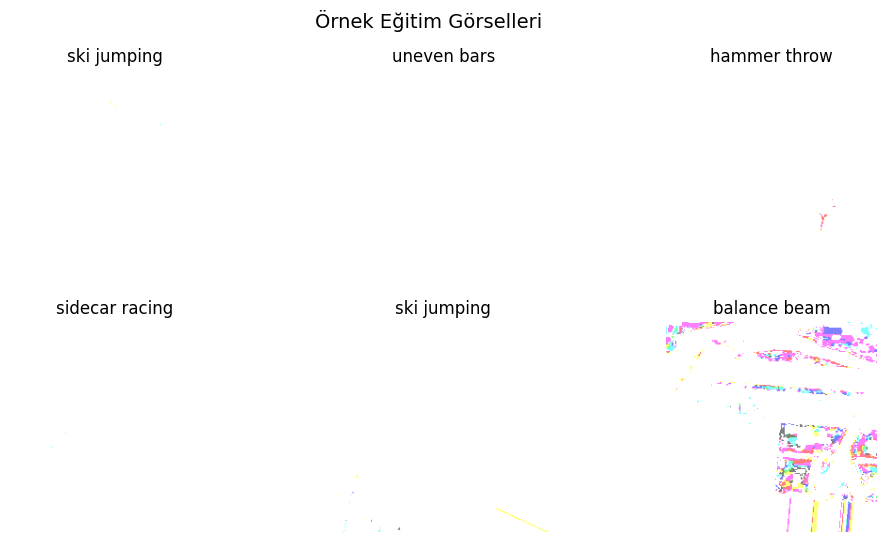

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


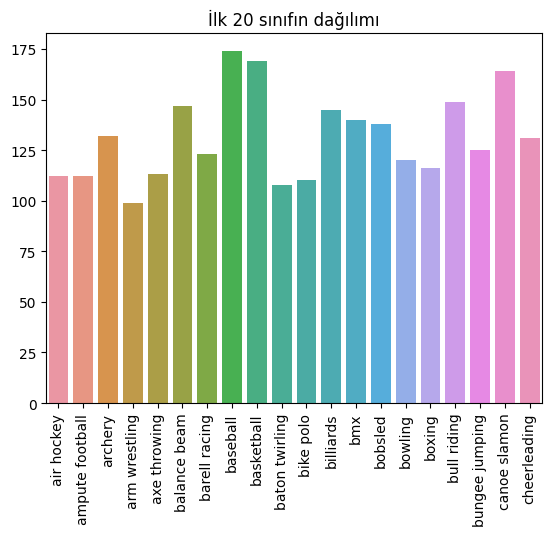

In [6]:
# HÜCRE 4 - Düzeltilmiş görüntüleme (preprocess_input ile gelen görüntüyü 0..1 aralığına getiriyoruz)
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    img = x_batch[i]
    # EfficientNet preprocess_input sonuçları tipik olarak -1..1 aralığında olur => geri çevir
    img_disp = (img + 1.0) / 2.0
    img_disp = np.clip(img_disp, 0, 1)
    plt.imshow(img_disp)
    plt.title(list(train_generator.class_indices.keys())[np.argmax(y_batch[i])])
    plt.axis("off")
plt.suptitle("Örnek Eğitim Görselleri", fontsize=14)
plt.show()

# Sınıf dağılımı (daha doğru sayım için pathlib kullan)
from pathlib import Path
class_counts = {}
for cls in train_generator.class_indices.keys():
    class_dir = Path(train_data_dir) / cls
    class_counts[cls] = len(list(class_dir.glob('*')))
sns.barplot(x=list(class_counts.keys())[:20], y=list(class_counts.values())[:20])
plt.xticks(rotation=90)
plt.title("İlk 20 sınıfın dağılımı")
plt.show()


# Hücre 5 – Modelin Kurulması

EfficientNetB0 önceden eğitilmiş ağ (ImageNet üzerinde) taban model olarak alınıyor.

Üst katmanları kapatılıp (trainable=False) kendi veri setimize uygun yeni katmanlar ekleniyor:

Global Average Pooling

Dense (512 nöron) + Dropout (0.5)

Çıkış katmanı (softmax, sınıf sayısı kadar nöron)

Model derleniyor (Adam optimizer, categorical_crossentropy loss).

🔹 Bu aşama, transfer learning ile kendi sınıflandırma modelimizi oluşturuyor.

In [7]:
# EfficientNetB0 tabanlı model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # önce donduruyoruz

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,756,743 (18.15 MB)

 Trainable params: 707,172 (2.70 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

# Hücre 6 – Eğitim Ayarları ve Modelin Eğitimi

Class Weights → Dengesiz sınıflarda her sınıfın eşit öğrenmesini sağlıyor.

TensorBoard → Eğitim sürecini görselleştirmek için log tutuluyor.

EarlyStopping → Model fazla öğrenmeye başlayıp ezberlerse erken durduruyor.

Model Fit → Eğitim ve doğrulama verileriyle model eğitiliyor (10 epoch).

🔹 Bu aşama, modelin öğrenme sürecini başlatıyor.

In [8]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


# TensorBoard (opsiyonel)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stopping, tensorboard_cb]
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1758906159.894744     105 service.cc:148] XLA service 0x78fa84005440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758906159.895859     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758906159.895885     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758906162.100512     105 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758906172.495631     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.0898 - loss: 4.3179

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


339/339 ━━━━━━━━━━━━━━━━━━━━ 295s 779ms/step - accuracy: 0.0901 - loss: 4.3166 - val_accuracy: 0.6080 - val_loss: 2.6816
Epoch 2/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 186s 549ms/step - accuracy: 0.4764 - loss: 2.5098 - val_accuracy: 0.7536 - val_loss: 1.4548
Epoch 3/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 183s 539ms/step - accuracy: 0.6259 - loss: 1.5899 - val_accuracy: 0.7773 - val_loss: 1.0654
Epoch 4/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 187s 550ms/step - accuracy: 0.6986 - loss: 1.2200 - val_accuracy: 0.8010 - val_loss: 0.8847
Epoch 5/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 182s 537ms/step - accuracy: 0.7398 - loss: 1.0307 - val_accuracy: 0.8281 - val_loss: 0.7552
Epoch 6/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 181s 534ms/step - accuracy: 0.7608 - loss: 0.9115 - val_accuracy: 0.8213 - val_loss: 0.6996
Epoch 7/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 183s 541ms/step - accuracy: 0.7740 - loss: 0.8316 - val_accuracy: 0.8424 - val_loss: 0.6541
Epoch 8/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 184s 542ms/step - accuracy: 0.8002 - loss: 0.74

# Hücre 7 – Eğitim Sonuçlarının Görselleştirilmesi

Eğitim sırasında kaydedilen accuracy ve loss değerleri grafikleştirilerek gösteriliyor.

Eğitim (train) ve doğrulama (validation) eğrileri karşılaştırılıyor.

🔹 Amaç: Modelin öğrenme eğrisini görmek, overfitting olup olmadığını kontrol etmek.

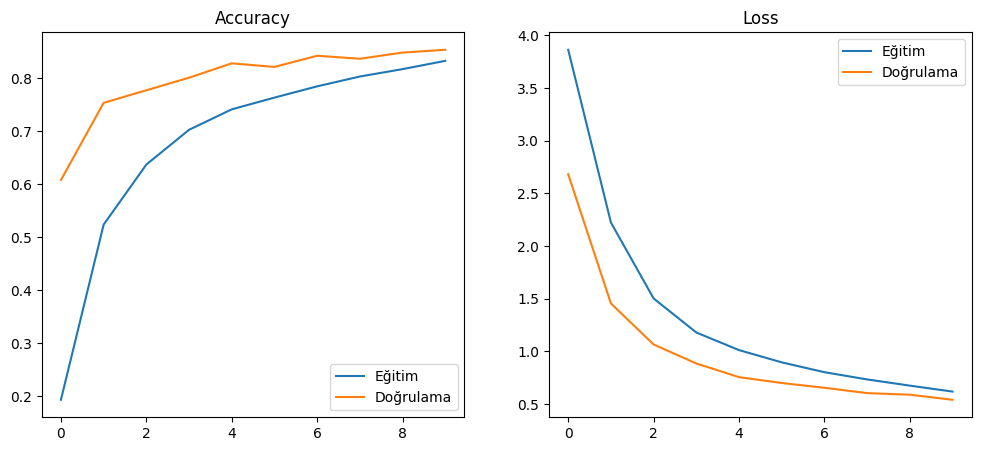

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="Eğitim")
plt.plot(epochs_range, val_acc, label="Doğrulama")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Eğitim")
plt.plot(epochs_range, val_loss, label="Doğrulama")
plt.legend()
plt.title("Loss")
plt.show()


# Hücre 8 – Test Verisi ile Değerlendirme

Model, hiç görmediği test verisi üzerinde deneniyor.

Test accuracy ve test loss değerleri yazdırılıyor.

🔹 Bu aşama, modelin gerçek performansını ölçüyor.

In [10]:
test_loss, test_acc = model.evaluate(test_generator)
print("="*40)
print("Test Accuracy:", round(test_acc,4))
print("Test Loss:", round(test_loss,4))
print("="*40)


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 584ms/step - accuracy: 0.9376 - loss: 0.2441
Test Accuracy: 0.942
Test Loss: 0.2473


# Hücre 9 – Classification Report & Confusion Matrix

Test setinde tahminler alınıyor.

Classification Report (precision, recall, f1-score) yazdırılıyor.

Confusion Matrix görselleştiriliyor (ilk 20 sınıf için).

🔹 Amaç: Modelin hangi sınıflarda başarılı, hangi sınıflarda hatalı olduğunu görmek.

Found 500 images belonging to 100 classes.
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 537ms/step
Classification Report:

                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       1.00      0.80      0.89         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       0.83      1.00      0.91         5
         balance beam       1.00      1.00      1.00         5
        barell racing       1.00      1.00      1.00         5
             baseball       1.00      0.80      0.89         5
           basketball       0.83      1.00      0.91         5
       baton twirling       1.00      1.00      1.00         5
            bike polo       0.71      1.00      0.83         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.40      0.57         5
        

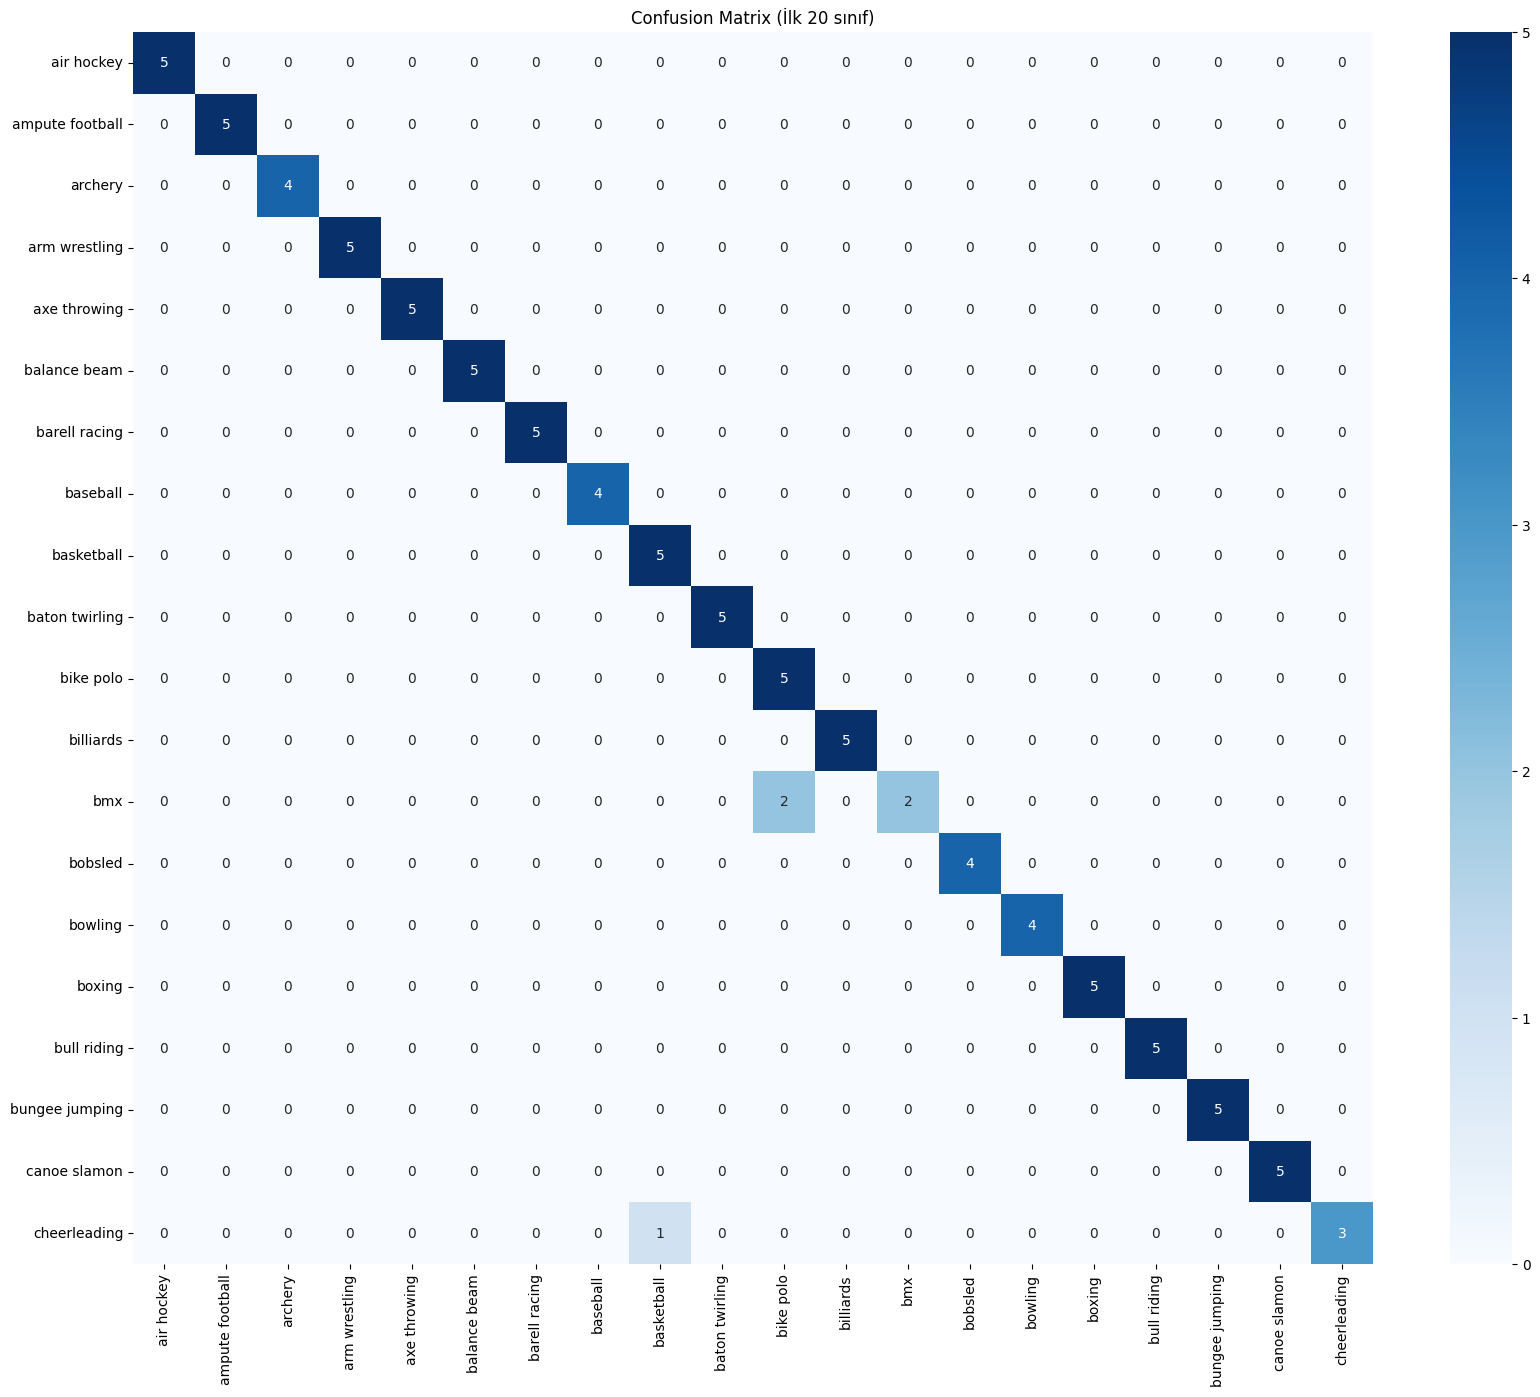

In [11]:
# HÜCRE 9 - Düzeltilmiş: test generator preprocess_input ile oluşturuluyor ve predict tutarlı
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

test_datagen_fixed = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator_fixed = test_datagen_fixed.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Tahminler (predict generator ile uyumlu)
y_true = test_generator_fixed.classes
y_pred_probs = model.predict(test_generator_fixed, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
target_names = list(test_generator_fixed.class_indices.keys())
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 16))
sns.heatmap(conf_matrix[:20, :20], annot=True, fmt="d", cmap="Blues", xticklabels=target_names[:20], yticklabels=target_names[:20])
plt.title("Confusion Matrix (İlk 20 sınıf)")
plt.show()


# Hücre 10 – Grad-CAM Görselleştirmesi

Modelin karar verirken resimde hangi bölgelere dikkat ettiğini görmek için Grad-CAM uygulanıyor.

Son convolution katmanından gradyan bilgisi alınarak ısı haritası oluşturuluyor.

Isı haritası orijinal görselin üzerine bindiriliyor.

🔹 Bu aşama, modelin neden o sınıfı seçtiğini görselleştirmeye yarıyor (açıklanabilir yapay zeka).

Son Conv layer: top_conv


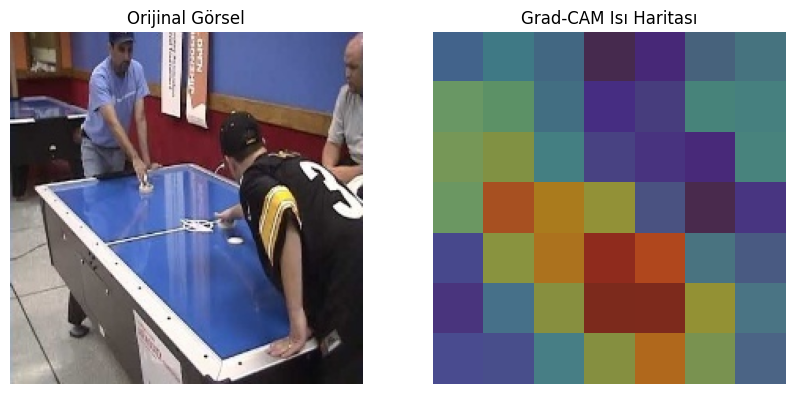

In [12]:
# HÜCRE 10 - Düzeltilmiş Grad-CAM (görüntüyü preprocess_input ile hazırlıyoruz)
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input

# Son Conv katmanını daha güvenli şekilde bul
last_conv_layer = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or 'conv' in layer.name.lower():
        last_conv_layer = layer
        break
print("Son Conv layer:", last_conv_layer.name)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # Model input'u listeye sarmadan verdik (uyarıyı önlemek için)
    grad_model = Model(model.input, 
                       [model.get_layer(last_conv_layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

# Bir test görseli seçelim ve doğru şekilde preprocess edelim
img_path = test_generator.filepaths[0]
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))

# Hem PIL hem array ayrı tutuyoruz
img_array = tf.keras.preprocessing.image.img_to_array(img)  # NumPy array (0..255 float)
input_array = np.expand_dims(img_array, axis=0)
input_preprocessed = preprocess_input(input_array.copy())  # EfficientNet için doğru ön işlem

# Heatmap üret
heatmap = make_gradcam_heatmap(input_preprocessed, model, last_conv_layer.name)

# Görselleştirme
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img)  # Orijinal PIL görselini göster
plt.title("Orijinal Görsel")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img)  # Arka plan yine orijinal görsel
plt.imshow(heatmap, cmap="jet", alpha=0.4)  # Üstüne ısı haritası
plt.title("Grad-CAM Isı Haritası")
plt.axis("off")
plt.show()


# Hücre 11 – Hiperparametre Optimizasyonu (Keras Tuner)

Keras Tuner ile farklı parametreler deneniyor:

Dense katman boyutu (256, 512, 1024)

Dropout oranı (0.3, 0.5, 0.7)

Learning rate (1e-4, 1e-3)

Random Search ile en iyi parametreler seçiliyor.

🔹 Amaç: Modelin performansını daha da iyileştirmek için en uygun ayarları bulmak.

In [13]:
!pip install -q keras-tuner

import keras_tuner as kt

def build_model(hp):
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Dense layer boyutu
    x = Dense(hp.Choice("dense_units", values=[256, 512, 1024]), activation="relu")(x)
    
    # Dropout oranı
    x = Dropout(hp.Choice("dropout_rate", values=[0.3, 0.5, 0.7]))(x)
    
    outputs = Dense(train_generator.num_classes, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("lr", values=[1e-4, 1e-3])
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,  # daha fazla arama için yükseltebilirsin
    executions_per_trial=1,
    overwrite=True,
    directory="my_dir",
    project_name="sports_tuning"
)

tuner.search(train_generator,
             validation_data=validation_generator,
             epochs=5)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("En iyi hiperparametreler:")
print("Dense units:", best_hps.get("dense_units"))
print("Dropout:", best_hps.get("dropout_rate"))
print("Learning rate:", best_hps.get("lr"))


Trial 5 Complete [00h 16m 03s]
val_accuracy: 0.8472535610198975

Best val_accuracy So Far: 0.866064727306366
Total elapsed time: 01h 19m 45s
En iyi hiperparametreler:
Dense units: 256
Dropout: 0.5
Learning rate: 0.001
